/var/folders/2d/ws36b6y52l9fm56tq6l10zm00000gn/T/ipykernel_69693/1256641964.py:353: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.880000000001019' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'Cash'] = cash
/var/folders/2d/ws36b6y52l9fm56tq6l10zm00000gn/T/ipykernel_69693/1256641964.py:353: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-7443.000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'Cash'] = cash


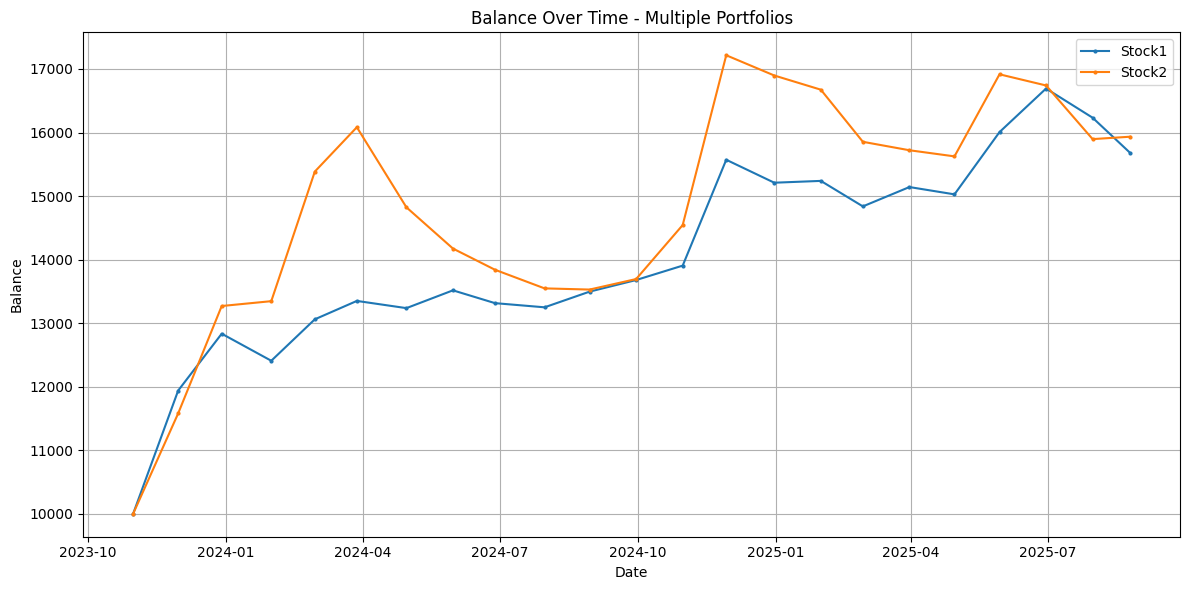

,Name,Symbol,Start Date,End Date,Start Balance,End Balance,Annualized Return (CAGR),Standard Deviation,Sharpe Ratio,Maximum Drawdown
0,Stock1,"[AFYA, AMAT, ASGN, ASTL, ASX, BATL, BIO, BJ, B...",2023-10-31,2025-08-25,10000,15679.28,0.278031,0.189128,1.235677,-0.060682


,Name,Symbol,Start Date,End Date,Start Balance,End Balance,Annualized Return (CAGR),Standard Deviation,Sharpe Ratio,Maximum Drawdown
0,Stock2,"[AFYA, AMAT, ASGN, ASTL, ASX, BATL, BIO, BJ, B...",2023-10-31,2025-08-25,10000,15933.98,0.289314,0.260156,0.988366,-0.158838


In [ ]:
from matplotlib.dates import relativedelta
from regex import F
from assetAllocation import AssetAllocation
from commonHelper import EDateType
import commonHelper
from dataDownloader import DataDownloader
from db_financialStatement import DB_FinancialStatement
from portfolio import Portfolio
import yfinance as yf
import pandas as pd
import numpy as np

pd.set_option('future.no_silent_downcasting', True)

start_date = '2021-12-01'
end_date = '2025-08-26'


def strategy_quarter_rank(symbols_dfs:dict, df_ncva_rank:pd.DataFrame, date_dict:dict, init_balance = 10000, is_use_mma = False):
    
    # 이평선 필터를 사용할지에 대한 유무
    def filter_mma(symbol, result_close, mma, restart_assets):
        # 이평선보다 낮은 애들은 리벨런싱에서 제외한다.
        compare_to_dict = dict(zip(symbol, zip(result_close, mma)))
        filter_restart_assets = [sym for sym in restart_assets if compare_to_dict[sym][0] > compare_to_dict[sym][1]]
        return filter_restart_assets
    
    # 
    
    df = AssetAllocation.merge_to_dfs(symbols_dfs)

    columns = [col for col in df.columns if col not in ['Adj Close','Close','Dividends','Condition']]
    df = df[columns]

    # 도중에 상폐된 심볼에 대한 제거
    symbol_counts = df['Symbol'].astype(str).value_counts()
    main_pattern = symbol_counts.index[0]
    df = df[df['Symbol'].astype(str) == main_pattern].reset_index()
    df = df.drop(columns=["index"])

    df['End Balance'] = None        # 지난 달 Restart Asset의 결과        
    df['Restart Asset'] = None      # 현 월 마지막에 리벨런싱 처리할 대상
    df['Restart Balance'] = None    # 리벨런싱의 자산 배분
    df['Cash'] = 0                  # 현금 보유 상황
    df['Balance'] = None            # 토탈 비용
    df['Do Rebalance'] = False      # 현 월에 리벨런싱이 되었나
    df['Quarter'] = None

    # "MMA_숫자" 컬럼이름 찾기 >> 후에 값이 변경될수도 있으니 
    mma_col = [col for col in df.columns if col.lower().startswith("mma_")][0]
    display(mma_col)

    for i in range(len(df)):
        date = df.at[i,'Date']
        curr_restart_assets = []

        for quarter, (start, end) in date_dict.items():
            if start <= date <= end:
                curr_restart_assets = df_ncva_rank[quarter].dropna().tolist()
                df.at[i, 'Quarter'] = quarter
                break

        curr_restart_assets_len = len(curr_restart_assets)

        if i == 0:
            if curr_restart_assets_len == 0:
                df.at[0, 'Cash'] = init_balance # 자산배분할게 없다면 현금으로 보유한다.
            else:

                filter_restart_assets = filter_mma(df.at[i, 'Symbol'], df.at[i, 'Result Close'], df.at[i, mma_col], curr_restart_assets)
                filter_restart_assets_len = len(filter_restart_assets)
                balance_unit = round(init_balance//curr_restart_assets_len)
                diff_len = curr_restart_assets_len - filter_restart_assets_len
                start_balances = [balance_unit]* len(filter_restart_assets)
                restart_balance = [0]*filter_restart_assets_len

                df.at[i, 'Restart Asset'] = filter_restart_assets
                df.at[i, 'Cash'] = balance_unit * diff_len
                df.at[i, 'Restart Balance'] = start_balances
                df.at[i, 'End Balance'] = restart_balance
            
            df.at[i, 'Balance'] = init_balance
        
        else:    
            # LocalFunc
            def get_result_close(symbols, closes, restart_assets):
                symbol_to_close = dict(zip(symbols, closes))
                restart_result_close = [symbol_to_close.get(sym, 0) for sym in restart_assets] # 이전달 종가 데이터
                return restart_result_close
            
            prev_restart_assets = df.at[i-1, 'Restart Asset']

            if prev_restart_assets is not None and len(prev_restart_assets) > 0:
                prev_result_close = get_result_close(df.at[i-1, 'Symbol'], df.at[i-1,'Result Close'], prev_restart_assets)
                curr_result_close = get_result_close(df.at[i, 'Symbol'], df.at[i,'Result Close'], prev_restart_assets)

                change_factors = [
                    curr_result_close[j] / prev_result_close[j]
                    if prev_result_close[j] != 0 else 0
                    for j in range(len(prev_result_close))
                ]

                try:
                    restart_balance = [
                        round(df.at[i-1, 'Restart Balance'][j] * change_factors[j], 2) 
                        for j in range(len(change_factors))
                    ]
                except Exception as e:
                    display(df)
                    raise RuntimeError(f"에러 발생!")
                
                total_balance = sum(restart_balance) + df.at[i-1, 'Cash']

                df.at[i,'End Balance'] = restart_balance
                df.at[i,'Balance'] = total_balance

            else: # 이전달이 Cash만 보유한 경우
                total_balance = df.at[i-1, 'Cash'] # 이전달 캐시를 결과 값으로.
                df.at[i, 'End Balance'] = None
                df.at[i, 'Balance'] = total_balance
 
            # 리벨런싱 할 대상이 있다면,
            if curr_restart_assets_len > 0:
                filter_restart_assets = filter_mma(df.at[i, 'Symbol'], df.at[i, 'Result Close'], df.at[i, mma_col], curr_restart_assets)
                filter_restart_assets_len = len(filter_restart_assets)

                if filter_restart_assets_len == 0:
                    df.at[i, 'Cash'] = total_balance
                    continue
                
                df.at[i, 'Restart Asset'] = filter_restart_assets


                # 이전에 현금만 보유했다면? 다른거 하지말고 나눠서 투자하면 된다.
                if prev_restart_assets == None or len(prev_restart_assets) == 0:
                    balance_unit = round(init_balance//curr_restart_assets_len)
                    diff_len = curr_restart_assets_len - filter_restart_assets_len

                    df.at[i, 'Restart Balance'] = [balance_unit] * filter_restart_assets_len
                    df.at[i, 'Cash'] = balance_unit * diff_len
                    continue


                if prev_restart_assets == filter_restart_assets:
                    df.at[i, 'Restart Balance'] = restart_balance
                    df.at[i, 'Cash'] = df.at[i-1, 'Cash']
                else:
                    prev_result_dict = dict(zip(prev_restart_assets,  df.at[i,'End Balance']))

                    # 그리고, 분기변화가 있을때 or 없을때에 대한 처리를 해야함.
                    prev_quarter = df.at[i-1, 'Quarter']
                    curr_quarter = df.at[i, 'Quarter']

                    # 이게 같다? 분기변화가 없다 >> 이평선 이탈 or 진입만 체크하면 됨
                    if prev_quarter == curr_quarter:
                        accum_balance = 0
                        new_assets = []
                        prev_assets = []
                        restart_balance = []

                        for sym in filter_restart_assets: 
                            if sym in prev_result_dict:
                                accum_balance += prev_result_dict[sym]
                                prev_assets.append(sym)
                                restart_balance.append(prev_result_dict[sym])
                            else:
                                new_assets.append(sym)
                            
                        # 기존껀 그대로 유지하고 남은돈
                        left_balance = total_balance - accum_balance

                        # 새로 진입할 녀석이 있다면?
                        if len(new_assets) > 0:
                            decide_balance = min(total_balance//filter_restart_assets_len, # 한개의 주식에 자산배분을 할때 최소한의 자산
                                                left_balance//len(new_assets)) # 현재 보유한 현금에서 분배할수 있는 한개의 자산

                            new_balances = [decide_balance] * len(new_assets)
                            
                            # 합치기
                            prev_assets.extend(new_assets)
                            restart_balance.extend(new_balances)
                            
                            df.at[i, 'Restart Asset'] = prev_assets
                            df.at[i, 'Restart Balance'] = restart_balance
                            df.at[i, 'Cash'] =  max(0, left_balance - sum(new_balances))
            
                        # 없다면? >> 더 빠진거 >> 현금으로 보유한다.
                        else:
                            df.at[i, 'Restart Balance'] = restart_balance
                            df.at[i, 'Cash'] = left_balance

                    else:
                        df.at[i, 'Restart Balance'] = [total_balance//filter_restart_assets_len] * filter_restart_assets_len
                        df.at[i, 'Do Rebalance'] = True
                                
            else:
                df.at[i, 'Cash'] = total_balance

    return df




def strategy_quarter_rankV2(symbols_dfs:dict, df_rank:pd.DataFrame, date_dict:dict, init_balance = 10000, is_use_mma = False):
    
    max_invest_balance = 2000

    # 이평선에 따른 필터링 처리
    def filter_mma(symbol, result_close, mma, restart_assets):
        # 이평선보다 낮은 애들은 리벨런싱에서 제외한다.
        compare_to_dict = dict(zip(symbol, zip(result_close, mma)))
        filter_restart_assets = [sym for sym in restart_assets if compare_to_dict[sym][0] >= compare_to_dict[sym][1]]
        return filter_restart_assets
    
    # 다음 보유 자산 구하기
    def get_restart_assets(curr_assets:list, is_use_mma):
            result_assets = []
            # 리스타트 필터링
            if not curr_assets:
                print(f"리스트가 비어있음 : {date}")
            else:
                # 여기서 필터링을 할건지 안할건지 체크
                result_assets = (
                    filter_mma(
                        df.at[i, 'Symbol'],
                        df.at[i, 'Result Close'],
                        df.at[i, mma_col],
                        curr_assets
                    )
                    if is_use_mma else curr_assets
                ) 
            return result_assets
    
    # 이전달에 투자한 자산의 결과 리스트 반환
    def get_end_balance(prev_assets, s_symbol, s_close, e_symbol, e_close):
        end_balance = []
        if prev_assets:
            start_close_dict = dict(zip(s_symbol, s_close))
            end_close_dict = dict(zip(e_symbol, e_close))

            change_ratio = [
                end_close_dict[sym] / start_close_dict[sym]
                if start_close_dict[sym] != 0
                    else 0
                for sym in prev_assets
            ]
            start_balance = df.at[i-1, 'Restart Balance']
            end_balance = [round(x*y,2) for x,y in zip(start_balance, change_ratio)]
            df.at[i, 'End Balance'] = end_balance

        return end_balance
    
    df = AssetAllocation.merge_to_dfs(symbols_dfs)

    columns = [col for col in df.columns if col not in ['Adj Close','Close','Dividends','Condition']]
    df = df[columns]

    # 도중에 상폐된 심볼에 대한 제거
    symbol_counts = df['Symbol'].astype(str).value_counts()
    main_pattern = symbol_counts.index[0]
    df = df[df['Symbol'].astype(str) == main_pattern].reset_index()
    df = df.drop(columns=["index"])

    df['End Balance'] = None        # 지난 달 Restart Asset의 결과        
    df['Restart Asset'] = None      # 현 월 마지막에 리벨런싱 처리할 대상
    df['Restart Balance'] = None    # 리벨런싱의 자산 배분
    df['Cash'] = 0                  # 현금 보유 상황
    df['Balance'] = None            # 토탈 비용
    df['Do Rebalance'] = False      # 현 월에 리벨런싱이 되었나
    df['Quarter'] = None            # 쿼터 값

    # "MMA_숫자" 컬럼이름 찾기 >> 후에 값이 변경될수도 있으니 
    mma_col = [col for col in df.columns if col.lower().startswith("mma_")][0]

    
    for i in range(len(df)):
        date = df.at[i, 'Date']

        # 이번 분기의 랭크 데이터
        quarter_rank_assets = []
        for q, (start, end) in date_dict.items():
            if start <= date <= end:
                df.at[i, 'Quarter'] = q
                
                if q in df_rank.columns:
                    quarter_rank_assets = df_rank[q].dropna().tolist()

        # 자산배분 플로우
        curr_assets = get_restart_assets(quarter_rank_assets, is_use_mma)
        df.at[i, 'Restart Asset'] = curr_assets

        if i == 0:
            if not curr_assets:
                df.at[0, 'Cash'] = init_balance
            else:
                # 한 재산에 투자할 수 있는 맥시멈 가격 : 1000으로 잡아놓음
                curr_assets_len = len(curr_assets)
                one_invest_balance = min(max_invest_balance, init_balance//curr_assets_len)

                df.at[0, 'Restart Balance'] = [one_invest_balance] * curr_assets_len
                df.at[0, 'Cash'] = init_balance - (one_invest_balance*curr_assets_len)
            
            df.at[0, 'Balance'] =init_balance
        else:  
            prev_assets = df.at[i-1, 'Restart Asset']

            end_balance = get_end_balance(prev_assets, 
                                          df.at[i-1,'Symbol'], 
                                          df.at[i-1,'Result Close'],
                                          df.at[i, 'Symbol'],
                                          df.at[i, 'Result Close'])
                    
            now_total_balance = (
                 df.at[i-1, 'Cash']
                if not end_balance
                    else  df.at[i-1, 'Cash'] + sum(end_balance)
            )

            df.at[i, 'Balance'] = now_total_balance

            if not curr_assets:
                df.at[i, 'Cash'] = now_total_balance       
            else:
                # 지난번과 같으니 그냥 그대로 쭉 진행
                if prev_assets == curr_assets:
                    df.at[i, 'Restart Balance'] = end_balance
                    df.at[i, 'Cash'] = df.at[i-1, 'Cash']

                # 아니라면? (분기 리벨런싱이 이루어졌거나, 아니면 이평선 아웃으로 인해 나감)
                else:
                    curr_assets_len = len(curr_assets)
                    one_invest_balance = min(max_invest_balance, now_total_balance//curr_assets_len)

                    restart_balance = []
                    cash = 0
            
                    if df.at[i,'Quarter'] != df.at[i-1, 'Quarter']:
                        restart_balance = [one_invest_balance] * curr_assets_len
                        cash = now_total_balance - (one_invest_balance*curr_assets_len)
                        df.at[i, 'Do Rebalance'] = True
                    else:
                        prev_balance_dict = dict(zip(prev_assets, end_balance))
                        
                        for sym in curr_assets:
                            if sym in prev_balance_dict:
                                restart_balance.append(prev_balance_dict[sym])
                            else:
                                restart_balance.append(one_invest_balance)

                        cash = now_total_balance - sum(restart_balance)

                    df.at[i, 'Restart Balance'] = restart_balance
                    df.at[i, 'Cash'] = cash


    return df


                
        




df_rank = DB_FinancialStatement.get_upgrade_super_value_rank_table()
df_rank = df_rank.head(20)

symbols = list(set(val for val in df_rank.values.ravel() if pd.notna(val)))
quarter_list = df_rank.columns.to_list()

date_dict = commonHelper.get_date_dict_by_quarter_lazy(quarter_list)
date_dict = commonHelper.get_trimmed_date_dict(date_dict, start_date, end_date)

quarter_list = [q for q in quarter_list if q in date_dict]

date_dict = commonHelper.adjust_start_data_dict_by_quarter(date_dict, quarter_list[0])
oldest, latest = commonHelper.get_date_range_from_quarters(date_dict)

df = AssetAllocation.get_stock_data_with_ma(symbols=symbols, start_date=oldest, end_date=latest, mas=[10], type='ma_month', use_db_stock=True)
df = AssetAllocation.filter_close_last_month(df)

# Portfolio.show_portfolio([
#     {'Stock1' : strategy_quarter_rankV2(df, df_rank, date_dict)},
#     {'Stock2' : strategy_quarter_rankV2(df, df_rank, date_dict, 10000, True)}
# ])


Portfolio.show_portfolio_stock()
